# Import Necessary Libraries

In [1]:
from warnings import filterwarnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate, train_test_split
from sklearn.preprocessing import LabelEncoder
from textblob import Word, TextBlob
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import nltk
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("vader_lexicon")

filterwarnings("ignore")
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 500)
pd.set_option("display.float_format", lambda x: '%.2f' % x)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


# Import Dataset

In [53]:
df = pd.read_csv("/content/amazon_review.csv", sep=",")
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,day_diff,helpful_yes,total_vote
0,A3SBTW3WS4IQSN,B007WTAJTO,NaN,"[0, 0]",No issues.,4.00,Four Stars,1406073600,2014-07-23,138,0,0
1,A18K1ODH1I2MVB,B007WTAJTO,0mie,"[0, 0]","Purchased this for my device, it worked as adv...",5.00,MOAR SPACE!!!,1382659200,2013-10-25,409,0,0
2,A2FII3I2MBMUIA,B007WTAJTO,1K3,"[0, 0]",it works as expected. I should have sprung for...,4.00,nothing to really say....,1356220800,2012-12-23,715,0,0
3,A3H99DFEG68SR,B007WTAJTO,1m2,"[0, 0]",This think has worked out great.Had a diff. br...,5.00,Great buy at this price!!! *** UPDATE,1384992000,2013-11-21,382,0,0
4,A375ZM4U047O79,B007WTAJTO,2&amp;1/2Men,"[0, 0]","Bought it with Retail Packaging, arrived legit...",5.00,best deal around,1373673600,2013-07-13,513,0,0


# Text Processing

In [4]:
def text_preprocessing(dataframe, dependent_var):
  # Step 1: Convert Text to Lowercase
  dataframe[dependent_var] = dataframe[dependent_var].apply(lambda x: " ".join(x.lower() for x in str(x).split()))

  # Step 2: Remove Punctuation
  dataframe[dependent_var] = dataframe[dependent_var].str.replace('[^\w\s]','')

  # Step 3: Remove Numeric Characters
  dataframe[dependent_var] = dataframe[dependent_var].str.replace('\d','')

  # Step 4: Eliminate Common Stop Words
  sw = stopwords.words('english')
  dataframe[dependent_var] = dataframe[dependent_var].apply(lambda x: " ".join(x for x in x.split() if x not in sw))

  # Step 5: Eliminate Rare Words
  temp_df = pd.Series(' '.join(dataframe[dependent_var]).split()).value_counts()
  drops = temp_df[temp_df <= 1]
  dataframe[dependent_var] = dataframe[dependent_var].apply(lambda x: " ".join(x for x in str(x).split() if x not in drops))

  # Step 6: Lemmatize Words
  dataframe[dependent_var] = dataframe[dependent_var].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

  return dataframe


In [5]:
df = text_preprocessing(df, "reviewText")

In [6]:
df["reviewText"].head()

0                                                issue
1    purchased device worked advertised never much ...
2    work expected higher capacity think made bit e...
3    think worked gb card went south one held prett...
4    bought retail packaging arrived legit envelope...
Name: reviewText, dtype: object

# Text Visualization

In [7]:
def text_visulaization(dataframe, dependent_var, barplot=True, wordcloud=True):
  # Step 1: Calculate Term Frequencies
  tf = dataframe[dependent_var].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis=0).reset_index()
  tf.columns = ["words", "tf"]

  if barplot:
    # Step 2: Create Bar Plot for Term Frequencies
    tf[tf["tf"] > 1000].plot.barh(x="words", y="tf")
    plt.title("Term Frequencies Bar Plot")
    plt.show()

  if wordcloud:
    # Step 3: Generate WordCloud
    text = " ".join(i for i in dataframe[dependent_var])
    wordcloud = WordCloud(max_font_size=100, max_words=1000, background_color="white").generate(text)
    plt.figure(figsize=[10, 10])
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title("Term Frequencies WordCloud")
    plt.show()
    wordcloud.to_file("wordcloud.png")


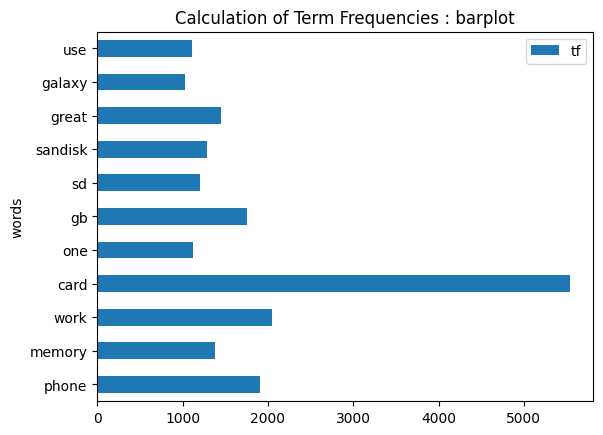

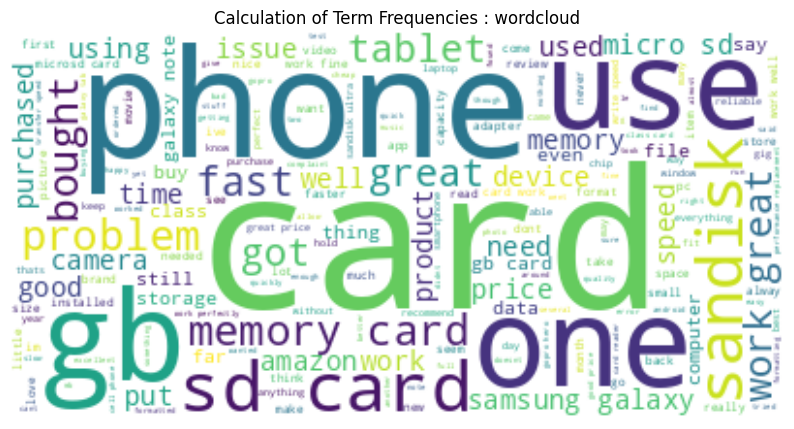

In [8]:
text_visulaization(df, "reviewText")

# Sentiment Analysis

In [9]:
def create_polarity_scores(dataframe, dependent_var):
  # Step 1: Initialize the Sentiment Intensity Analyzer (SIA)
  sia = SentimentIntensityAnalyzer()

  # Step 2: Calculate Polarity Scores for Each Text in the DataFrame
  dataframe["polarity_score"] = dataframe[dependent_var].apply(lambda x: sia.polarity_scores(x)["compound"])


In [10]:
# Calculate Polarity Scores for the 'reviewText' Column
create_polarity_scores(df, "reviewText")

In [11]:
#View the processed data 
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,day_diff,helpful_yes,total_vote,polarity_score
0,A3SBTW3WS4IQSN,B007WTAJTO,NaN,"[0, 0]",issue,4.00,Four Stars,1406073600,2014-07-23,138,0,0,0.00
1,A18K1ODH1I2MVB,B007WTAJTO,0mie,"[0, 0]",purchased device worked advertised never much ...,5.00,MOAR SPACE!!!,1382659200,2013-10-25,409,0,0,0.00
2,A2FII3I2MBMUIA,B007WTAJTO,1K3,"[0, 0]",work expected higher capacity think made bit e...,4.00,nothing to really say....,1356220800,2012-12-23,715,0,0,0.40
3,A3H99DFEG68SR,B007WTAJTO,1m2,"[0, 0]",think worked gb card went south one held prett...,5.00,Great buy at this price!!! *** UPDATE,1384992000,2013-11-21,382,0,0,0.65
4,A375ZM4U047O79,B007WTAJTO,2&amp;1/2Men,"[0, 0]",bought retail packaging arrived legit envelope...,5.00,best deal around,1373673600,2013-07-13,513,0,0,0.86


# Feature Engineering

In [12]:
# Create Labels for Sentiment Classification
def create_label(dataframe, dependent_var, independent_var):
  # Step 1: Initialize the Sentiment Intensity Analyzer (SIA)
  sia = SentimentIntensityAnalyzer()

  # Step 2: Assign 'pos' or 'neg' labels based on polarity scores
  dataframe[independent_var] = dataframe[dependent_var].apply(lambda x: "pos" if sia.polarity_scores(x)["compound"] > 0 else "neg")

  # Step 3: Encode the labels ('pos' and 'neg') into numerical values
  dataframe[independent_var] = LabelEncoder().fit_transform(dataframe[independent_var])

  # Step 4: Prepare feature (X) and label (y) datasets
  X = dataframe[dependent_var]
  y = dataframe[independent_var]

  return X, y


In [13]:
# Create feature (X) and label (y) datasets for sentiment analysis
X, y = create_label(df, "reviewText", "sentiment_label")

In [14]:
# Split Dataset into Training and Testing Sets
def split_dataset(dataframe, X, y):
  # Step 1: Split the feature (X) and label (y) datasets into training and testing sets
  train_x, test_x, train_y, test_y = train_test_split(X, y, random_state=1)
  return train_x, test_x, train_y, test_y


In [15]:
# Split the feature (X) and label (y) datasets into training and testing sets
train_x, test_x, train_y, test_y = split_dataset(df, X, y)


In [16]:
# Create Count Vectorizer Features
def create_features_count(train_x, test_x):
  # Step 1: Initialize a Count Vectorizer
  vectorizer = CountVectorizer()
  
  # Step 2: Transform training and testing text data into Count Vectors
  x_train_count_vectorizer = vectorizer.fit_transform(train_x)
  x_test_count_vectorizer = vectorizer.transform(test_x)

  return x_train_count_vectorizer, x_test_count_vectorizer


In [17]:
# Create Count Vectorizer Features for Training and Testing Data
x_train_count_vectorizer, x_test_count_vectorizer = create_features_count(train_x, test_x)


In [18]:
# Create TF-IDF Word Features
def create_features_TFIDF_word(train_x, test_x):
  # Step 1: Initialize a TF-IDF Word Vectorizer
  tf_idf_word_vectorizer = TfidfVectorizer()
  
  # Step 2: Transform training text data into TF-IDF Word Vectors
  x_train_tf_idf_word = tf_idf_word_vectorizer.fit_transform(train_x)
  
  # Step 3: Transform testing text data into TF-IDF Word Vectors (using the same vectorizer)
  x_test_tf_idf_word = tf_idf_word_vectorizer.transform(test_x)

  return x_train_tf_idf_word, x_test_tf_idf_word


In [19]:
# Create TF-IDF Word Features for Training and Testing Data
x_train_tf_idf_word, x_test_tf_idf_word = create_features_TFIDF_word(train_x, test_x)

In [20]:
# Create TF-IDF N-gram Features
def create_features_TFIDF_ngram(train_x, test_x):
  # Step 1: Initialize a TF-IDF N-gram Vectorizer with a range of 2 to 3 (bigrams and trigrams)
  tf_idf_ngram_vectorizer = TfidfVectorizer(ngram_range=(2, 3))
  
  # Step 2: Transform training text data into TF-IDF N-gram Vectors
  x_train_tf_idf_ngram = tf_idf_ngram_vectorizer.fit_transform(train_x)
  
  # Step 3: Transform testing text data into TF-IDF N-gram Vectors (using the same vectorizer)
  x_test_tf_idf_ngram = tf_idf_ngram_vectorizer.transform(test_x)

  return x_train_tf_idf_ngram, x_test_tf_idf_ngram


In [21]:
# Create TF-IDF N-gram Features for Training and Testing Data
x_train_tf_idf_ngram, x_test_tf_idf_ngram = create_features_TFIDF_ngram(train_x, test_x)


In [22]:
# Create TF-IDF Character Features
def create_features_TFIDF_chars(train_x, test_x):
  # Step 1: Initialize a TF-IDF Character Vectorizer with character-level analysis and a range of 2 to 3 (bigrams and trigrams)
  tf_idf_chars_vectorizer = TfidfVectorizer(analyzer="char", ngram_range=(2, 3))
  
  # Step 2: Transform training text data into TF-IDF Character Vectors
  x_train_tf_idf_chars = tf_idf_chars_vectorizer.fit_transform(train_x)
  
  # Step 3: Transform testing text data into TF-IDF Character Vectors (using the same vectorizer)
  x_test_tf_idf_chars = tf_idf_chars_vectorizer.transform(test_x)

  return x_train_tf_idf_chars, x_test_tf_idf_chars


In [23]:
#Create TF-IDF Character Features for Training and Testing Data
x_train_tf_idf_chars, x_test_tf_idf_chars = create_features_TFIDF_chars(train_x, test_x)

# Sentiment Modeling - Create Model

In [24]:
# Logistic Regression Model Creation and Evaluation
def crate_model_logistic(train_x, test_x):
    # Step 1: Create Count Vector Features and Train a Logistic Regression Model
    x_train_count_vectorizer, x_test_count_vectorizer = create_features_count(train_x, test_x)
    loj_count = LogisticRegression(solver='lbfgs', max_iter=1000)
    loj_model_count = loj_count.fit(x_train_count_vectorizer, train_y)
    accuracy_count = cross_val_score(loj_model_count, x_test_count_vectorizer, test_y, cv=10).mean()
    print("Accuracy - Count Vectors: %.3f" % accuracy_count)

    # Step 2: Create TF-IDF Word Features and Train a Logistic Regression Model
    x_train_tf_idf_word, x_test_tf_idf_word = create_features_TFIDF_word(train_x, test_x)
    loj_word = LogisticRegression(solver='lbfgs', max_iter=1000)
    loj_model_word = loj_word.fit(x_train_tf_idf_word, train_y)
    accuracy_word = cross_val_score(loj_model_word, x_test_tf_idf_word, test_y, cv=10).mean()
    print("Accuracy - TF-IDF Word: %.3f" % accuracy_word)

    # Step 3: Create TF-IDF N-gram Features and Train a Logistic Regression Model
    x_train_tf_idf_ngram, x_test_tf_idf_ngram = create_features_TFIDF_ngram(train_x, test_x)
    loj_ngram = LogisticRegression(solver='lbfgs', max_iter=1000)
    loj_model_ngram = loj_ngram.fit(x_train_tf_idf_ngram, train_y)
    accuracy_ngram = cross_val_score(loj_model_ngram, x_test_tf_idf_ngram, test_y, cv=10).mean()
    print("Accuracy TF-IDF ngram: %.3f" % accuracy_ngram)

    # Step 4: Train a Logistic Regression Model using TF-IDF Character Features
    loj_chars = LogisticRegression(solver='lbfgs', max_iter=1000)
    loj_model_chars = loj_chars.fit(x_train_tf_idf_chars, train_y)
    accuracy_chars = cross_val_score(loj_model_chars, x_test_tf_idf_chars, test_y, cv=10).mean()
    print("Accuracy TF-IDF Characters: %.3f" % accuracy_chars)

    return loj_model_count, loj_model_word, loj_model_ngram, loj_model_chars


In [25]:
# Create and Train Logistic Regression Models with Different Features
loj_model_count, loj_model_word, loj_model_ngram, loj_model_chars = crate_model_logistic(train_x, test_x)


Accuracy - Count Vectors: 0.832
Accuracy - TF-IDF Word: 0.801
Accuracy TF-IDF ngram: 0.802
Accuracy TF-IDF Characters: 0.803


In [26]:
# Random Forest
def crate_model_randomforest(train_x, test_x):
  # Count
  x_train_count_vectorizer, x_test_count_vectorizer = create_features_count(train_x, test_x)
  rf_count = RandomForestClassifier()
  rf_model_count = rf_count.fit(x_train_count_vectorizer, train_y)
  accuracy_count = cross_val_score(rf_model_count, x_test_count_vectorizer, test_y, cv=10).mean()
  print("Accuracy - Count Vectors: %.3f" % accuracy_count)

  # TF-IDF Word
  x_train_tf_idf_word, x_test_tf_idf_word = create_features_TFIDF_word(train_x, test_x)
  rf_word = RandomForestClassifier()
  rf_model_word = rf_word.fit(x_train_tf_idf_word, train_y)
  accuracy_word = cross_val_score(rf_model_word, x_test_tf_idf_word, test_y, cv=10).mean()
  print("Accuracy - TF-IDF Word: %.3f" % accuracy_word)

  # TF-IDF ngram
  x_train_tf_idf_ngram, x_test_tf_idf_ngram = create_features_TFIDF_ngram(train_x, test_x)
  rf_ngram = RandomForestClassifier()
  rf_model_ngram = rf_ngram.fit(x_train_tf_idf_ngram, train_y)
  accuracy_ngram = cross_val_score(rf_model_ngram, x_test_tf_idf_ngram, test_y, cv=10).mean()
  print("Accuracy TF-IDF ngram: %.3f" % accuracy_ngram)

  # TF-IDF chars

  rf_chars = RandomForestClassifier()
  rf_model_chars = rf_chars.fit(x_train_tf_idf_chars, train_y)
  accuracy_chars = cross_val_score(rf_model_chars, x_test_tf_idf_chars, test_y, cv=10).mean()
  print("Accuracy TF-IDF Characters: %.3f" % accuracy_chars)

  return rf_model_count, rf_model_word, rf_model_ngram, rf_model_chars

In [27]:
rf_model_count, rf_model_word, rf_model_ngram, rf_model_chars = crate_model_randomforest(train_x, test_x)

Accuracy - Count Vectors: 0.811
Accuracy - TF-IDF Word: 0.804
Accuracy TF-IDF ngram: 0.738
Accuracy TF-IDF Characters: 0.803


# Model Tuning

In [28]:
def model_tuning_randomforest(train_x, test_x):
  # Count
  x_train_count_vectorizer, x_test_count_vectorizer = create_features_count(train_x, test_x)
  rf_model_count = RandomForestClassifier(random_state=1)
  rf_params = {"max_depth": [2,5,8, None],
               "max_features": [2,5,8, "auto"],
               "n_estimators": [100,500,1000],
               "min_samples_split": [2,5,10]}
  rf_best_grid = GridSearchCV(rf_model_count, rf_params, cv=10, n_jobs=-1, verbose=False).fit(x_train_count_vectorizer, train_y)
  rf_model_count_final = rf_model_count.set_params(**rf_best_grid.best_params_, random_state=1).fit(x_train_count_vectorizer, train_y)
  accuracy_count = cross_val_score(rf_model_count_final, x_test_count_vectorizer, test_y, cv=10).mean()
  print("Accuracy - Count Vectors: %.3f" % accuracy_count)

  return rf_model_count_final

In [30]:
rf_model_count_final = model_tuning_randomforest(train_x, test_x)

Accuracy - Count Vectors: 0.812


# Prediction

In [33]:
def predict_count(train_x, model, new_comment):
  new_comment= pd.Series(new_comment)
  new_comment = CountVectorizer().fit(train_x).transform(new_comment)
  result = model.predict(new_comment)
  if result==1:
    print("Comment is Pozsitive")
  else:
    print("Comment is Negative")

In [34]:
# Logistic Regression
predict_count(train_x, model=loj_model_count, new_comment="this product is very good :)")

Comment is Pozitive


In [35]:
# Random Forest
predict_count(train_x, model=rf_model_count, new_comment="this product is very bad :)")

Comment is Negative


In [42]:
# Sample Review
new_comments = pd.Series(df["reviewText"].sample(3).values)
new_comments


0    scandisk ultra gb class microsdhc card one ace...
1                                                issue
2    never issue good work well tablet super fast r...
dtype: object

In [50]:
# Sample Review - Random Forest
for comment in new_comments:
    predict_count(train_x, rf_model_count, comment)

Comment is Pozitive
Comment is Negative
Comment is Pozitive


In [1]:
#Sample review by user
com = "Product is very nice"
predict_count(train_x, rf_model_count, com)

NameError: name 'predict_count' is not defined